In [2]:
import os
import json
import pandas as pd
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
from dotenv import load_dotenv
import matplotlib.pyplot as plt

### Loading gurobi license

In [3]:
load_dotenv()

license_file = os.getenv('GRB_LICENSE_FILE')
print(f"Gurobi license file: {license_file}")


Gurobi license file: /Users/tepin/Documents/ttu/op_research/projects/or_project/gurobi.lic


### Loading the provided data sample

In [4]:
file_path = "data/OR_United.json"

with open(file_path, 'r') as file:
    raw_data = json.load(file)
raw_data[0:10]

[{'Recipient': 'B', 'Donor': ['AB']},
 {'Recipient': 'A', 'Donor': ['AB', 'B']},
 {'Recipient': 'A', 'Donor': ['AB']},
 {'Recipient': 'O', 'Donor': ['AB']},
 {'Recipient': 'A', 'Donor': ['AB']},
 {'Recipient': 'A', 'Donor': ['AB']},
 {'Recipient': 'O', 'Donor': ['A']},
 {'Recipient': 'O', 'Donor': ['B']},
 {'Recipient': 'O', 'Donor': ['AB', 'B', 'A']},
 {'Recipient': 'B', 'Donor': ['AB', 'A']}]

In [5]:
len(raw_data)

767

### Exploratory Data Analysis

In [6]:
df = pd.DataFrame(raw_data)
recipient_counts = df['Recipient'].value_counts()
donors_flat = [donor for sublist in df['Donor'] for donor in sublist]
donor_counts = pd.Series(donors_flat).value_counts()


print(f"Recipient Counts: {len(raw_data)}")
print("Recipient Counts by Blood Type:")
print(recipient_counts)
print("\nDonor Counts by Blood Type:")
print(donor_counts)

Recipient Counts: 767
Recipient Counts by Blood Type:
Recipient
O    263
B    255
A    249
Name: count, dtype: int64

Donor Counts by Blood Type:
AB    604
B     392
A     392
Name: count, dtype: int64


##### The unmatched entries

In [7]:
all_donors = [donor for donors in df['Donor'] for donor in donors]
nodes_no_incoming = df[~df['Recipient'].isin(all_donors)]
print("Nodes with no incoming arcs (unmatched recipients):")
print(f"count: {len(nodes_no_incoming)}")
print(nodes_no_incoming.head())

nodes_no_outgoing = df[df['Donor'].apply(lambda donors: all(donor == 'AB' for donor in donors))]
print("Nodes with no outgoing arcs (cannot donate to anyone):")
print(f"count: {len(nodes_no_outgoing)}")
print(nodes_no_outgoing.head())

nodes_no_incoming = df[~df['Recipient'].isin(all_donors)]
nodes_no_outgoing = df[df['Donor'].apply(lambda donors: all(donor == 'AB' for donor in donors))]
nodes_no_incoming_outgoing = nodes_no_incoming[nodes_no_incoming.index.isin(nodes_no_outgoing.index)]
print("Nodes with no incoming AND no outgoing arcs:")
print(f"count: {len(nodes_no_incoming_outgoing)}")
print(nodes_no_incoming_outgoing.head())

Nodes with no incoming arcs (unmatched recipients):
count: 263
   Recipient       Donor
3          O        [AB]
6          O         [A]
7          O         [B]
8          O  [AB, B, A]
12         O      [A, B]
Nodes with no outgoing arcs (cannot donate to anyone):
count: 130
  Recipient Donor
0         B  [AB]
2         A  [AB]
3         O  [AB]
4         A  [AB]
5         A  [AB]
Nodes with no incoming AND no outgoing arcs:
count: 13
    Recipient Donor
3           O  [AB]
24          O  [AB]
36          O  [AB]
58          O  [AB]
146         O  [AB]


### Building the graph from the raw data

In [8]:
def get_arcs(raw_data):
    compatibility = {
        'O': ['O', 'A', 'B', 'AB'],
        'A': ['A', 'AB'],
        'B': ['B', 'AB'],
        'AB': ['AB']
    }

    sample_arcs = []
    for recipient_index, recipient_data in enumerate(raw_data):
        recipient_blood = recipient_data['Recipient']
        for donor_index, donor_data in enumerate(raw_data):
            if donor_index != recipient_index:
                donor_blood_types = donor_data['Donor']
                if any(recipient_blood in compatibility[donor_blood] for donor_blood in donor_blood_types):
                    sample_arcs.append((donor_index, recipient_index))

    # return sample_arcs
        # Include all nodes (isolated or not)
    all_nodes = list(range(len(raw_data)))  # Node indices from the dataset

    return sample_arcs, all_nodes



In [9]:
def set_graph(arcs, all_nodes):
    G = nx.DiGraph()
    G.add_nodes_from(all_nodes)
    G.add_edges_from(arcs)
    return G

In [10]:
def draw_graph(arcs, selected_edges):
    """
    Auxiliary function to draw the optimal solution graph with highlighted 2-cycles and 3-cycles.
    """
    G = nx.DiGraph()
    G.add_edges_from(arcs)

    pos = nx.spring_layout(G, k=0.85, iterations=10, seed=42)
    plt.figure(figsize=(9, 5))
    
    # Draw all edges in light gray
    nx.draw_networkx_edges(G, pos, edgelist=arcs, arrowstyle='-|>', arrowsize=20, edge_color='lightgray', style='dashed')
    
    # Highlight 2-cycles and 3-cycles
    two_cycles = []
    three_cycles = []

    # Check for 2-cycles
    for (i, j) in selected_edges:
        if (j, i) in selected_edges:
            two_cycles.append((i, j))
            two_cycles.append((j, i))

    # Check for 3-cycles
    for (i, j) in selected_edges:
        for (j2, k) in selected_edges:
            if j == j2 and (k, i) in selected_edges:
                three_cycles.append((i, j))
                three_cycles.append((j, k))
                three_cycles.append((k, i))

    # Remove duplicates from cycles
    two_cycles = list(set(two_cycles))
    three_cycles = list(set(three_cycles))

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
    
    # Draw selected edges in default color
    nx.draw_networkx_edges(G, pos, edgelist=selected_edges, arrowstyle='-|>', arrowsize=20, edge_color='gray')
    
    # Draw 2-cycles in blue
    nx.draw_networkx_edges(G, pos, edgelist=two_cycles, arrowstyle='-|>', arrowsize=20, edge_color='blue', width=2)
    
    # Draw 3-cycles in orange
    nx.draw_networkx_edges(G, pos, edgelist=three_cycles, arrowstyle='-|>', arrowsize=20, edge_color='orange', width=2)
    
    plt.title("Disjoint Cycles Graph with Highlighted 2-cycles (Blue) and 3-cycles (Orange)")
    plt.axis('off')  # Hide the axes
    plt.show()

In [12]:
def remove_isolated_nodes(arcs, all_nodes):
# def remove_isolated_nodes(arcs):
    """
    Removes all nodes with 0 outgoing or 0 incoming edges from the graph.

    **Parameters:**
        - `arcs` (list of tuples): A list of directed edges (arcs) in the graph.

    **Returns:**
        - A filtered list of arcs with nodes that have either 0 outgoing or 0 incoming edges removed.
        - Prints the counts of removed nodes and their categories.
    """
    # Create a directed graph using NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(all_nodes)
    G.add_edges_from(arcs)

    # Find nodes with no incoming arcs
    nodes_no_incoming = {node for node in G.nodes() if G.in_degree(node) == 0}

    # Find nodes with no outgoing arcs
    nodes_no_outgoing = {node for node in G.nodes() if G.out_degree(node) == 0}

    # Find nodes with no incoming and no outgoing arcs (isolated)
    nodes_no_incoming_outgoing = {node for node in G.nodes() if ((G.out_degree(node) == 0) and (G.in_degree(node) == 0))}
    # nodes_no_incoming_outgoing = nodes_no_incoming.intersection(nodes_no_outgoing)

    # Combine all nodes to be removed
    nodes_to_remove = nodes_no_incoming.union(nodes_no_outgoing)

    # Print statistics
    print(f"Total nodes removed: {len(nodes_to_remove)}")
    print(f"Nodes with no incoming arcs: {len(nodes_no_incoming)}")
    print(f"Nodes with no outgoing arcs: {len(nodes_no_outgoing)}")
    print(f"Nodes with no incoming and no outgoing arcs: {len(nodes_no_incoming_outgoing)}")

    # Remove these nodes from the graph
    G.remove_nodes_from(nodes_to_remove)

    # Return the filtered list of edges
    return list(G.edges())

# Example usage:
# arcs = [(0, 1), (1, 2), (2, 0), (3, 4)]  # Replace this with your graph's edges
# filtered_arcs = remove_isolated_nodes(arcs)
# print(filtered_arcs)


In [13]:
def get_max_disjoint_cycles(arcs, draw=True):
    """
    Finds the maximum number of disjoint 2-cycles and 3-cycles in a directed graph using a Mixed Integer Programming (MIP) approach.

    This function formulates and solves an integer programming model to select the maximum
    number of edges that form disjoint cycles of length 2 or 3 in the given graph. It ensures
    that the selected cycles are disjoint (no shared nodes) and prevents the formation of cycles
    longer than length 3.

    **Parameters:**
        - `arcs` (list of tuples): A list of directed edges (arcs) in the graph. Each arc is represented
          as a tuple `(source_node, end_node)`, where `source_node` and `end_node` are integers
          ranging from 0 to `n - 1`, with `n` being the total number of nodes in the graph.

        - `draw` (bool, optional): If set to `True`, the function will visualize the original graph and
          highlight the selected edges that form 2-cycles and 3-cycles. Defaults to `True`.

    **Returns:**
        - None

    **Example:**

    ```
    arcs = [
        (0, 1), (1, 2), (2, 0),    # Cycle among 0-1-2
        (3, 4), (4, 5), (5, 3),    # Cycle among 3-4-5
        (6, 7), (7, 6),            # Cycle between 6-7
        (8, 9), (9, 8),            # Cycle between 8-9
        # Additional arcs...
    ]
    get_max_disjoint_cycles(arcs)
    ```
    """
    # Create a new Gurobi model
    model = gp.Model('Disjoint_Cycles')

    # Suppress Gurobi output
    model.setParam('OutputFlag', 0)

    # Create a directed graph using NetworkX
    G = nx.DiGraph()
    G.add_edges_from(arcs)
    nodes = list(G.nodes())

    # Create variables x_{ij} ∈ {0, 1} for each arc (i, j)
    x = {}
    for i, j in arcs:
        x[i, j] = model.addVar(vtype=GRB.BINARY, name=f'x_{i}_{j}')

    model.update()

    # Add flow conservation constraints
    for node in nodes:
        in_arcs = [(i, node) for i in G.predecessors(node)]
        out_arcs = [(node, j) for j in G.successors(node)]
        model.addConstr(
            gp.quicksum(x[i, node] for (i, node) in in_arcs) == gp.quicksum(x[node, j] for (node, j) in out_arcs),
            name=f'flow_conservation_{node}'
        )

    # Add degree constraints (number of incoming edges ≤ 1)
    for node in nodes:
        in_arcs = [(i, node) for i in G.predecessors(node)]
        model.addConstr(
            gp.quicksum(x[i, node] for (i, node) in in_arcs) <= 1,
            name=f'degree_in_{node}'
        )

    # Path length constraints
    for j in nodes:
        for i in G.predecessors(j):
            for v in G.successors(j):
                path_nodes = [i, j, v]
                distinct_nodes = set(path_nodes)

                # Check if the path forms a cycle (returns to the starting node)
                if len(distinct_nodes) == 3:
                    x_vi = x.get((v, i), 0)  # Returns 0 if (v, i) is not in x
                    in_arcs_i = gp.quicksum(x.get((k, i), 0) for k in G.predecessors(i))
                    out_arcs_v = gp.quicksum(x.get((v, k), 0) for k in G.successors(v))
                    # Add constraint to prevent selecting all edges in the cycle
                    model.addConstr(
                        (in_arcs_i - x_vi) + x[i, j] + x[j, v] + out_arcs_v <= 3,
                        name=f'cycle_constraint_{i}_{j}_{v}'
                    )

    # Objective function: Maximize the number of edges included
    model.setObjective(gp.quicksum(x[i, j] for (i, j) in x), GRB.MAXIMIZE)

    # Optimize the model
    model.optimize()

    # Extract and display the solution
    if model.Status == GRB.OPTIMAL:
        solution = model.getAttr('x', x)
        edges_selected = [(i, j) for (i, j), val in solution.items() if val > 0.5]

        # Build a graph from the selected edges
        G_selected = nx.DiGraph()
        G_selected.add_edges_from(edges_selected)

        # Find cycles in the selected edges
        cycles = list(nx.simple_cycles(G_selected))

        # Draw the graph
        if draw:
            draw_graph(arcs, edges_selected)

        # Print the cycles and their edges
        print("Optimal solution:")
        for cycle in cycles:
            cycle_edges = []
            for idx in range(len(cycle)):
                u = cycle[idx]
                v = cycle[(idx + 1) % len(cycle)]  # Next node in the cycle
                cycle_edges.append((u, v))
            # Format the output
            cycle_str = ", ".join(f"({u}, {v})" for u, v in cycle_edges)
            print(f"    {cycle_str}    # Cycle {'-'.join(map(str, cycle))}")
    else:
        print("No optimal solution found.")


In [14]:
def get_max_disjoint_cycles_cycle_algorithm(arcs, draw=True):
    """
    Finds the maximum number of disjoint 2-cycles and 3-cycles in a directed graph using an optimized MIP approach.
    """
    # Create a directed graph using NetworkX
    G = nx.DiGraph()
    G.add_edges_from(arcs)
    nodes = list(G.nodes())

    # Precompute all cycles of length 2 and 3
    cycles = []

    # Cycles of length 2
    for u, v in G.edges():
        if G.has_edge(v, u):
            cycles.append({'nodes': [u, v], 'edges': [(u, v), (v, u)]})

    # Cycles of length 3
    for u in nodes:
        for v in G.successors(u):
            for w in G.successors(v):
                if G.has_edge(w, u) and u != v and v != w and w != u:
                    cycles.append({'nodes': [u, v, w], 'edges': [(u, v), (v, w), (w, u)]})

    # Create a new Gurobi model
    model = gp.Model('Disjoint_Cycles')
    model.setParam('OutputFlag', 0)  # Suppress Gurobi output

    # Create variables y_c ∈ {0, 1} for each cycle c
    y = {}
    for idx, cycle in enumerate(cycles):
        y[idx] = model.addVar(vtype=GRB.BINARY, name=f'y_{idx}')

    model.update()

    # Add constraints: Each node can be in at most one cycle
    for node in nodes:
        cycles_with_node = [idx for idx, cycle in enumerate(cycles) if node in cycle['nodes']]
        if cycles_with_node:
            model.addConstr(gp.quicksum(y[idx] for idx in cycles_with_node) <= 1, name=f'node_{node}')

    model.setObjective(gp.quicksum(y[idx] for idx in y), GRB.MAXIMIZE)

    model.optimize()

    if model.Status == GRB.OPTIMAL:
        selected_cycles = [cycles[idx] for idx in y if y[idx].X > 0.5]

        edges_selected = []
        for cycle in selected_cycles:
            edges_selected.extend(cycle['edges'])

        edges_selected = list(set(edges_selected))

        if draw:
            draw_graph(arcs, edges_selected)

        print("Optimal solution:")
        for cycle in selected_cycles:
            cycle_edges = cycle['edges']
            cycle_str = ", ".join(f"({u}, {v})" for u, v in cycle_edges)
            node_sequence = "-".join(map(str, cycle['nodes'] + [cycle['nodes'][0]]))
            print(f"    {cycle_str}    # Cycle {node_sequence}")
    else:
        print("No optimal solution found.")


In [16]:
def solve_path_based_models(G, draw=True):

    # Create a new Gurobi model
    model = gp.Model('Compact')

    # Suppress Gurobi output
    #model.setParam('OutputFlag', 0)

    # Create a directed graph using NetworkX
    #G = nx.DiGraph()
    #G.add_edges_from(arcs)
    #nodes = list(G.nodes())

    # Create variables x_{ij} ∈ {0, 1} for each arc (i, j)
    x = model.addVars(G.edges, vtype=GRB.BINARY, name= 'x')

    #model.update()
    
    # Add flow conservation constraints (2b)
    model.addConstrs(gp.quicksum(x[v, u] for u in G.successors(v)) <= 1 for v in G.nodes)

    # Add flow conservation constraints (2c)
    model.addConstrs(gp.quicksum(x[u, v] for u in G.predecessors(v)) == gp.quicksum(x[v, u] for u in G.successors(v)) for v in G.nodes)
    

    # Path length constraints (5c)
    #H = G.to_undirected()
    
    for j in G.nodes:
        print("j: ", j)
        for i in G.predecessors(j):
            for v in G.successors(j):
                if i == v: continue
                if (v ,i) in G.edges:
                    model.addConstr(x[i,j] + x[j,v] <= 1 + x[v,i])
                else:
                    model.addConstr(x[i,j] + x[j,v] <= 1)   
            

    # Objective function: Maximize the number of edges included
    model.setObjective(gp.quicksum(x), GRB.MAXIMIZE)

    # Optimize the model
    model.optimize()
    
    # Retrieve solutions
    selected_arcs = [arc for arc in G.edges if x[arc].x > 0.5]

    H = G.edge_subgraph(selected_arcs)

    for component in nx.weakly_connected_components(H):
        print("component:", list(component))

In [17]:
%%time
# sample_arcs = get_arcs(raw_data)
sample_arcs, all_nodes = get_arcs(raw_data)
print(len(sample_arcs))
filtered_arcs = remove_isolated_nodes(sample_arcs, all_nodes)
print(len(filtered_arcs))
get_max_disjoint_cycles_cycle_algorithm(filtered_arcs, draw=False)
get_max_disjoint_cycles_cycle_algorithm(sample_arcs, draw=False)

197568
Total nodes removed: 380
Nodes with no incoming arcs: 263
Nodes with no outgoing arcs: 130
Nodes with no incoming and no outgoing arcs: 13
74800
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-21
Optimal solution:
    (1, 15), (15, 1)    # Cycle 1-15-1
    (9, 13), (13, 9)    # Cycle 9-13-9
    (17, 101), (101, 17)    # Cycle 17-101-17
    (19, 20), (20, 19)    # Cycle 19-20-19
    (21, 29), (29, 21)    # Cycle 21-29-21
    (25, 46), (46, 25)    # Cycle 25-46-25
    (27, 48), (48, 27)    # Cycle 27-48-27
    (28, 50), (50, 28)    # Cycle 28-50-28
    (30, 52), (52, 30)    # Cycle 30-52-30
    (33, 61), (61, 33)    # Cycle 33-61-33
    (35, 64), (64, 35)    # Cycle 35-64-35
    (40, 88), (88, 40)    # Cycle 40-88-40
    (41, 70), (70, 41)    # Cycle 41-70-41
    (49, 73), (73, 49)    # Cycle 49-73-49
    (56, 82), (82, 56)    # Cycle 56-82-56
    (59, 10), (10, 59)    # Cycle 59-10-59
    (62, 89), (89, 62)    # Cycle 62-89-62
    (67, 65),

In [18]:
import timeit
code_snippet = """
sample_arcs, all_nodes = get_arcs(raw_data)
get_max_disjoint_cycles_cycle_algorithm(sample_arcs, draw=False)
"""

setup_code = """
from __main__ import get_arcs, get_max_disjoint_cycles_cycle_algorithm, raw_data
"""

execution_times = timeit.repeat(stmt=code_snippet, setup=setup_code, repeat=10, number=1)
average_time = sum(execution_times) / len(execution_times)

print(f"Average processing time: {average_time:.4f} seconds")


Optimal solution:
    (1, 27), (27, 1)    # Cycle 1-27-1
    (10, 9), (9, 10)    # Cycle 10-9-10
    (13, 35), (35, 13)    # Cycle 13-35-13
    (20, 15), (15, 20)    # Cycle 20-15-20
    (29, 17), (17, 29)    # Cycle 29-17-29
    (46, 19), (19, 46)    # Cycle 46-19-46
    (48, 21), (21, 48)    # Cycle 48-21-48
    (50, 49), (49, 50)    # Cycle 50-49-50
    (52, 30), (30, 52)    # Cycle 52-30-52
    (61, 33), (33, 61)    # Cycle 61-33-61
    (64, 28), (28, 64)    # Cycle 64-28-64
    (65, 41), (41, 65)    # Cycle 65-41-65
    (70, 107), (107, 70)    # Cycle 70-107-70
    (73, 25), (25, 73)    # Cycle 73-25-73
    (82, 56), (56, 82)    # Cycle 82-56-82
    (86, 59), (59, 86)    # Cycle 86-59-86
    (88, 62), (62, 88)    # Cycle 88-62-88
    (89, 67), (67, 89)    # Cycle 89-67-89
    (90, 76), (76, 90)    # Cycle 90-76-90
    (94, 80), (80, 94)    # Cycle 94-80-94
    (99, 84), (84, 99)    # Cycle 99-84-99
    (101, 93), (93, 101)    # Cycle 101-93-101
    (102, 40), (40, 102)    # Cycle 

In [19]:
import timeit
code_snippet = """
sample_arcs, all_nodes = get_arcs(raw_data)
filtered_arcs = remove_isolated_nodes(sample_arcs, all_nodes)
get_max_disjoint_cycles_cycle_algorithm(filtered_arcs, draw=False)
"""

setup_code = """
from __main__ import get_arcs, get_max_disjoint_cycles_cycle_algorithm, raw_data, remove_isolated_nodes
"""

execution_times = timeit.repeat(stmt=code_snippet, setup=setup_code, repeat=10, number=1)
average_time = sum(execution_times) / len(execution_times)

print(f"Average processing time: {average_time:.4f} seconds")


Total nodes removed: 380
Nodes with no incoming arcs: 263
Nodes with no outgoing arcs: 130
Nodes with no incoming and no outgoing arcs: 13
Optimal solution:
    (1, 15), (15, 1)    # Cycle 1-15-1
    (9, 13), (13, 9)    # Cycle 9-13-9
    (17, 101), (101, 17)    # Cycle 17-101-17
    (19, 20), (20, 19)    # Cycle 19-20-19
    (21, 29), (29, 21)    # Cycle 21-29-21
    (25, 46), (46, 25)    # Cycle 25-46-25
    (27, 48), (48, 27)    # Cycle 27-48-27
    (28, 50), (50, 28)    # Cycle 28-50-28
    (30, 52), (52, 30)    # Cycle 30-52-30
    (33, 61), (61, 33)    # Cycle 33-61-33
    (35, 64), (64, 35)    # Cycle 35-64-35
    (40, 88), (88, 40)    # Cycle 40-88-40
    (41, 70), (70, 41)    # Cycle 41-70-41
    (49, 73), (73, 49)    # Cycle 49-73-49
    (56, 82), (82, 56)    # Cycle 56-82-56
    (59, 10), (10, 59)    # Cycle 59-10-59
    (62, 89), (89, 62)    # Cycle 62-89-62
    (67, 65), (65, 67)    # Cycle 67-65-67
    (76, 86), (86, 76)    # Cycle 76-86-76
    (80, 94), (94, 80)    # Cyc

In [27]:
%%time
sample_arcs, all_nodes = get_arcs(raw_data)
G_path_based = set_graph(sample_arcs, all_nodes)
solve_path_based_models(G_path_based)

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18
j:  19
j:  20
j:  21
j:  22
j:  23
j:  24
j:  25
j:  26
j:  27
j:  28
j:  29
j:  30
j:  31
j:  32
j:  33
j:  34
j:  35
j:  36
j:  37
j:  38
j:  39
j:  40
j:  41
j:  42
j:  43
j:  44
j:  45
j:  46
j:  47
j:  48
j:  49
j:  50
j:  51
j:  52
j:  53
j:  54
j:  55
j:  56
j:  57
j:  58
j:  59
j:  60
j:  61
j:  62
j:  63
j:  64
j:  65
j:  66
j:  67
j:  68
j:  69
j:  70
j:  71
j:  72
j:  73
j:  74
j:  75
j:  76
j:  77
j:  78
j:  79
j:  80
j:  81
j:  82
j:  83
j:  84
j:  85
j:  86
j:  87
j:  88
j:  89
j:  90
j:  91
j:  92
j:  93
j:  94
j:  95
j:  96
j:  97
j:  98
j:  99
j:  100
j:  101
j:  102
j:  103
j:  104
j:  105
j:  106
j:  107
j:  108
j:  109
j:  110
j:  111
j:  112
j:  113
j:  114
j:  115
j:  116
j:  117
j:  118
j:  119
j:  120
j:  121
j:  122
j:  123
j:  124
j:  125
j:  126
j:  127
j:  128
j:  129
j:  130
j:  131
j:  132
j:  133
j:  134
j:  135
j:  136
j:  137
j:  13

/var/folders/bw/klb3s_v14tj47nwv021v4cm40000gn/T/ipykernel_10892/3502923681.py:41: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.setObjective(gp.quicksum(x), GRB.MAXIMIZE)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 38140854 rows, 197568 columns and 76871344 nonzeros
Model fingerprint: 0x1d008130
Variable types: 0 continuous, 197568 integer (197568 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 143 rows and 0 columns (presolve time = 40s) ...
Presolve removed 143 rows and 0 columns (presolve time = 41s) ...
Presolve removed 143 rows and 122768 columns (presolve time = 45s) ...
Presolve removed 23741080 rows and 122768 columns (presolve time = 50s) ...
Presolve removed 23741080 rows and 122768 columns (presolve time = 72s) ...
Presolve removed 23741080 ro

In [28]:
%%time
sample_arcs, all_nodes = get_arcs(raw_data)
filtered_arcs = remove_isolated_nodes(sample_arcs, all_nodes)
G_path_based = set_graph(filtered_arcs, all_nodes)
solve_path_based_models(G_path_based)

Total nodes removed: 380
Nodes with no incoming arcs: 263
Nodes with no outgoing arcs: 130
Nodes with no incoming and no outgoing arcs: 13
j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18
j:  19
j:  20
j:  21
j:  22
j:  23
j:  24
j:  25
j:  26
j:  27
j:  28
j:  29
j:  30
j:  31
j:  32
j:  33
j:  34
j:  35
j:  36
j:  37
j:  38
j:  39
j:  40
j:  41
j:  42
j:  43
j:  44
j:  45
j:  46
j:  47
j:  48
j:  49
j:  50
j:  51
j:  52
j:  53
j:  54
j:  55
j:  56
j:  57
j:  58
j:  59
j:  60
j:  61
j:  62
j:  63
j:  64
j:  65
j:  66
j:  67
j:  68
j:  69
j:  70
j:  71
j:  72
j:  73
j:  74
j:  75
j:  76
j:  77
j:  78
j:  79
j:  80
j:  81
j:  82
j:  83
j:  84
j:  85
j:  86
j:  87
j:  88
j:  89
j:  90
j:  91
j:  92
j:  93
j:  94
j:  95
j:  96
j:  97
j:  98
j:  99
j:  100
j:  101
j:  102
j:  103
j:  104
j:  105
j:  106
j:  107
j:  108
j:  109
j:  110
j:  111
j:  112
j:  113
j:  114
j:  115
j:  116
j:  117
j:  118
j:  119
j:  120
j: 

/var/folders/bw/klb3s_v14tj47nwv021v4cm40000gn/T/ipykernel_10892/3502923681.py:41: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.setObjective(gp.quicksum(x), GRB.MAXIMIZE)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 14400534 rows, 74800 columns and 29022400 nonzeros
Model fingerprint: 0xc931e5bc
Variable types: 0 continuous, 74800 integer (74800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 760 rows and 0 columns (presolve time = 6s) ...
Presolve removed 760 rows and 0 columns (presolve time = 10s) ...
Presolve removed 7161118 rows and 0 columns (presolve time = 17s) ...
Presolve removed 7573075 rows and 0 columns (presolve time = 20s) ...
Presolve removed 8212538 rows and 0 columns (presolve time = 25s) ...
Presolve removed 8663025 rows and 0 columns (presolve time = 30s) ...
Presolve removed 9234395 rows and 0 co

##### The unmatched nodes

In [23]:
nodes_in_cycles = {x[0]  for x in filtered_arcs}
entry_in_cycles = [raw_data[y] for y in nodes_in_cycles]
A_recipients = [r for r in entry_in_cycles if r['Recipient']=='A']
B_recipients = [r for r in entry_in_cycles if r['Recipient']=='B']
print(len(entry_in_cycles))
print(len(A_recipients))
print(len(B_recipients))
print(f'expected number of cycles: {min(len(A_recipients),len(B_recipients))}')

387
187
200
expected number of cycles: 187


## More testing cases

_Test cases to validate the methods implemented_

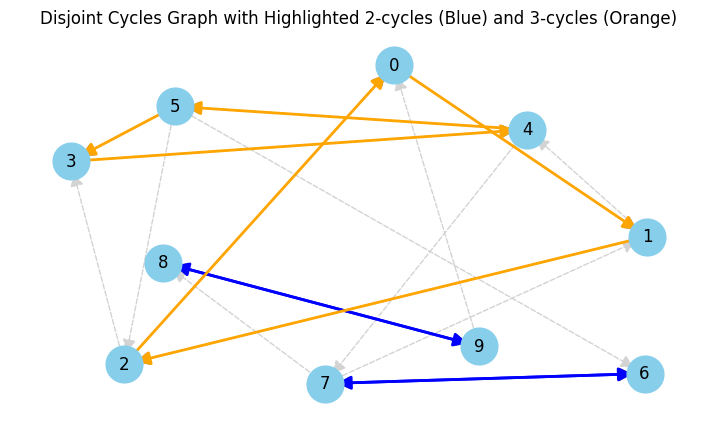

Optimal solution:
    (8, 9), (9, 8)    # Cycle 8-9
    (6, 7), (7, 6)    # Cycle 6-7
    (3, 4), (4, 5), (5, 3)    # Cycle 3-4-5
    (0, 1), (1, 2), (2, 0)    # Cycle 0-1-2


In [24]:
# Given arcs as example
arcs = [
    (0, 1), (1, 2), (2, 0),    # Cycle among 0-1-2
    (3, 4), (4, 5), (5, 3),    # Cycle among 3-4-5
    (6, 7), (7, 6),            # Cycle between 6-7
    (8, 9), (9, 8),            # Cycle between 8-9
    (2, 3), (5, 6),            # Connecting arcs
    (7, 8), (9, 0),            # Connecting arcs
    (1, 4), (4, 7), (7, 1),    # Cycle among 1-4-7
    (5, 2),                    # Additional arc
]
get_max_disjoint_cycles(arcs)


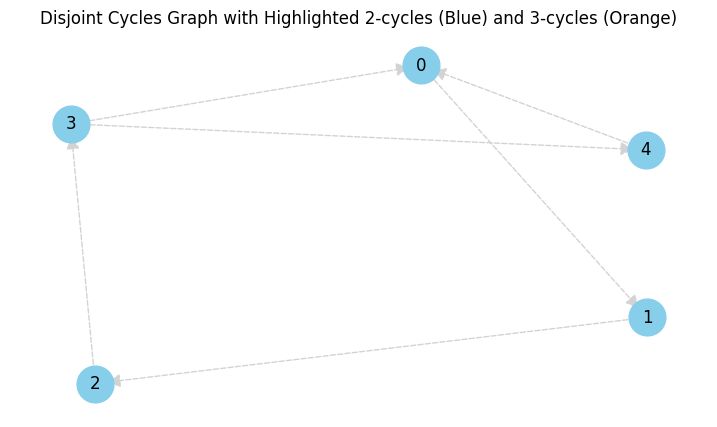

Optimal solution:


In [25]:
# this one should return no optimal solution
arcs = [
    (0, 1), (1, 2), (2, 3),(3,0), (3,4), (4,0)
]
get_max_disjoint_cycles(arcs)


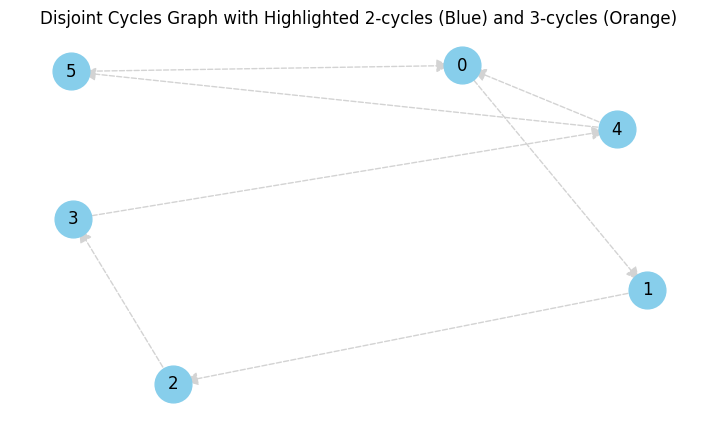

Optimal solution:


In [26]:
# this one should return no optimal solution
arcs = [
    (0, 1), (1, 2), (2, 3), (3,4), (4,0), (4,5), (5,0)
]
get_max_disjoint_cycles(arcs)


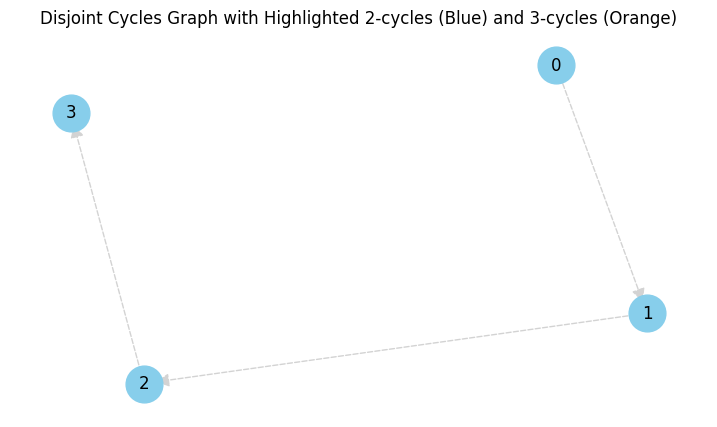

Optimal solution:


In [27]:
# this one should return no optimal solution
arcs = [
    (0, 1), (1, 2), (2, 3)
]
get_max_disjoint_cycles(arcs)


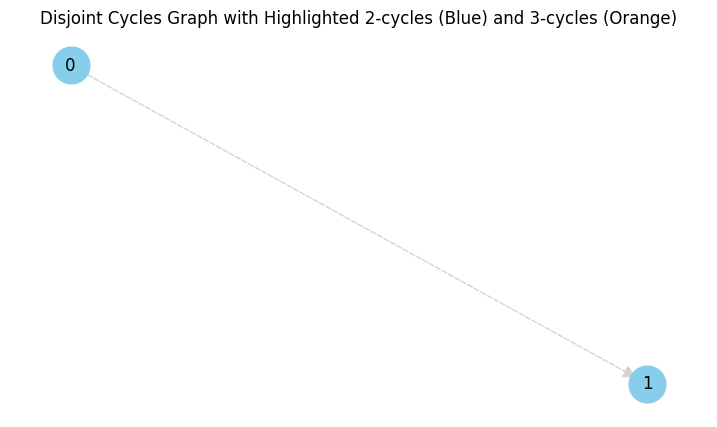

Optimal solution:


In [28]:
# this one should return no optimal solution
arcs = [
    (0, 1)
]
get_max_disjoint_cycles(arcs)


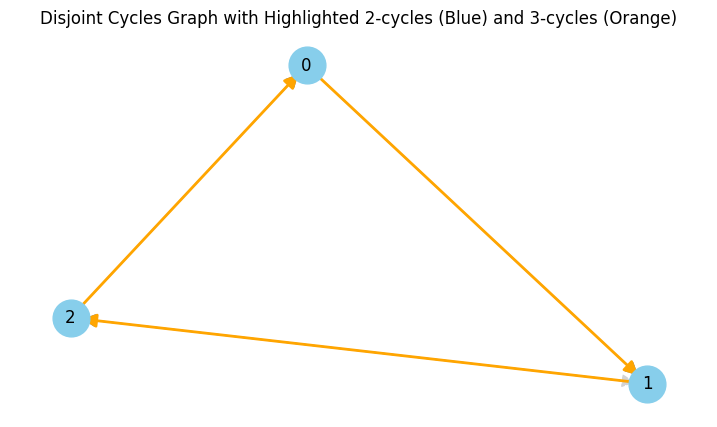

Optimal solution:
    (0, 1), (1, 2), (2, 0)    # Cycle 0-1-2


In [29]:
arcs = [
    (0, 1), (1, 2), (2, 1),(2,0)
]
get_max_disjoint_cycles(arcs)

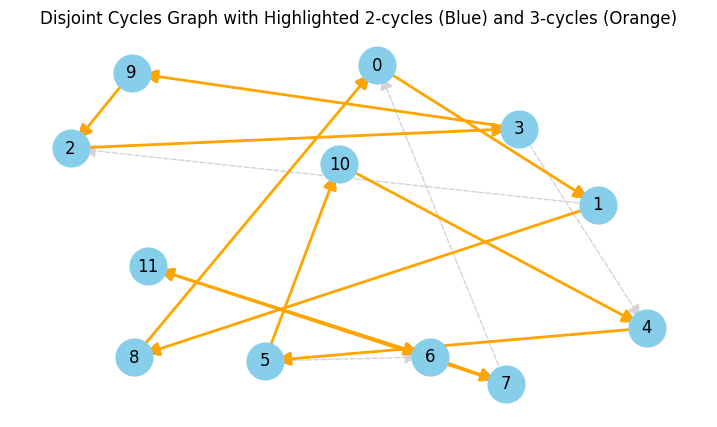

Optimal solution:
    (11, 6), (6, 7), (7, 11)    # Cycle 11-6-7
    (10, 4), (4, 5), (5, 10)    # Cycle 10-4-5
    (9, 2), (2, 3), (3, 9)    # Cycle 9-2-3
    (0, 1), (1, 8), (8, 0)    # Cycle 0-1-8


In [30]:
arcs = [
    (0, 1), (1, 8), (8, 0), 
    (1, 2), 
    (2, 3), (3, 9), (9, 2),
    (3, 4), 
    (4, 5), (5, 10), (10, 4),
    (5, 6), 
    (6, 7), (7, 11), (11, 6),
    (7, 0),
]
get_max_disjoint_cycles(arcs)

In [31]:
%%time
L = 20
arcs = [(i,j) for i in range(L) for j in range(L) if i!=j]
get_max_disjoint_cycles(arcs, draw=False)

Optimal solution:
    (18, 19), (19, 18)    # Cycle 18-19
    (16, 17), (17, 16)    # Cycle 16-17
    (14, 15), (15, 14)    # Cycle 14-15
    (12, 13), (13, 12)    # Cycle 12-13
    (10, 11), (11, 10)    # Cycle 10-11
    (8, 9), (9, 8)    # Cycle 8-9
    (6, 7), (7, 6)    # Cycle 6-7
    (4, 5), (5, 4)    # Cycle 4-5
    (2, 3), (3, 2)    # Cycle 2-3
    (0, 1), (1, 0)    # Cycle 0-1
CPU times: user 338 ms, sys: 21.5 ms, total: 359 ms
Wall time: 384 ms


In [32]:
%%time
L = 30
arcs = [(i,j) for i in range(L) for j in range(L) if i!=j]
get_max_disjoint_cycles(arcs, draw=False)

Optimal solution:
    (28, 29), (29, 28)    # Cycle 28-29
    (26, 27), (27, 26)    # Cycle 26-27
    (24, 25), (25, 24)    # Cycle 24-25
    (22, 23), (23, 22)    # Cycle 22-23
    (20, 21), (21, 20)    # Cycle 20-21
    (18, 19), (19, 18)    # Cycle 18-19
    (16, 17), (17, 16)    # Cycle 16-17
    (14, 15), (15, 14)    # Cycle 14-15
    (12, 13), (13, 12)    # Cycle 12-13
    (10, 11), (11, 10)    # Cycle 10-11
    (8, 9), (9, 8)    # Cycle 8-9
    (6, 7), (7, 6)    # Cycle 6-7
    (4, 5), (5, 4)    # Cycle 4-5
    (2, 3), (3, 2)    # Cycle 2-3
    (0, 1), (1, 0)    # Cycle 0-1
CPU times: user 2.01 s, sys: 90.9 ms, total: 2.1 s
Wall time: 2.2 s


In [33]:
%%time
L = 40
arcs = [(i,j) for i in range(L) for j in range(L) if i!=j]
get_max_disjoint_cycles(arcs, draw=False)

Optimal solution:
    (38, 39), (39, 38)    # Cycle 38-39
    (36, 37), (37, 36)    # Cycle 36-37
    (34, 35), (35, 34)    # Cycle 34-35
    (32, 33), (33, 32)    # Cycle 32-33
    (30, 31), (31, 30)    # Cycle 30-31
    (28, 29), (29, 28)    # Cycle 28-29
    (26, 27), (27, 26)    # Cycle 26-27
    (24, 25), (25, 24)    # Cycle 24-25
    (22, 23), (23, 22)    # Cycle 22-23
    (20, 21), (21, 20)    # Cycle 20-21
    (18, 19), (19, 18)    # Cycle 18-19
    (16, 17), (17, 16)    # Cycle 16-17
    (14, 15), (15, 14)    # Cycle 14-15
    (12, 13), (13, 12)    # Cycle 12-13
    (10, 11), (11, 10)    # Cycle 10-11
    (8, 9), (9, 8)    # Cycle 8-9
    (6, 7), (7, 6)    # Cycle 6-7
    (4, 5), (5, 4)    # Cycle 4-5
    (2, 3), (3, 2)    # Cycle 2-3
    (0, 1), (1, 0)    # Cycle 0-1
CPU times: user 8.01 s, sys: 473 ms, total: 8.48 s
Wall time: 8.9 s


In [34]:
%%time
L = 50
arcs = [(i,j) for i in range(L) for j in range(L) if i!=j]
get_max_disjoint_cycles(arcs, draw=False)

Optimal solution:
    (48, 49), (49, 48)    # Cycle 48-49
    (46, 47), (47, 46)    # Cycle 46-47
    (44, 45), (45, 44)    # Cycle 44-45
    (42, 43), (43, 42)    # Cycle 42-43
    (40, 41), (41, 40)    # Cycle 40-41
    (38, 39), (39, 38)    # Cycle 38-39
    (36, 37), (37, 36)    # Cycle 36-37
    (34, 35), (35, 34)    # Cycle 34-35
    (32, 33), (33, 32)    # Cycle 32-33
    (30, 31), (31, 30)    # Cycle 30-31
    (28, 29), (29, 28)    # Cycle 28-29
    (26, 27), (27, 26)    # Cycle 26-27
    (24, 25), (25, 24)    # Cycle 24-25
    (22, 23), (23, 22)    # Cycle 22-23
    (20, 21), (21, 20)    # Cycle 20-21
    (18, 19), (19, 18)    # Cycle 18-19
    (16, 17), (17, 16)    # Cycle 16-17
    (14, 15), (15, 14)    # Cycle 14-15
    (12, 13), (13, 12)    # Cycle 12-13
    (10, 11), (11, 10)    # Cycle 10-11
    (8, 9), (9, 8)    # Cycle 8-9
    (6, 7), (7, 6)    # Cycle 6-7
    (4, 5), (5, 4)    # Cycle 4-5
    (2, 3), (3, 2)    # Cycle 2-3
    (0, 1), (1, 0)    # Cycle 0-1
CPU times: u

## Comparing cycle and path based on complete graphs

Complete graphs of L=100 nodes

In [39]:
%%time
L = 100
arcs = [(i,j) for i in range(L) for j in range(L) if i!=j]
get_max_disjoint_cycles_cycle_algorithm(arcs, draw=False)

Optimal solution:
    (0, 8), (8, 0)    # Cycle 0-8-0
    (1, 7), (7, 1)    # Cycle 1-7-1
    (2, 3), (3, 2)    # Cycle 2-3-2
    (4, 5), (5, 4)    # Cycle 4-5-4
    (6, 9), (9, 6)    # Cycle 6-9-6
    (10, 11), (11, 10)    # Cycle 10-11-10
    (12, 14), (14, 12)    # Cycle 12-14-12
    (13, 16), (16, 13)    # Cycle 13-16-13
    (15, 20), (20, 15)    # Cycle 15-20-15
    (17, 21), (21, 17)    # Cycle 17-21-17
    (18, 19), (19, 18)    # Cycle 18-19-18
    (22, 23), (23, 22)    # Cycle 22-23-22
    (24, 32), (32, 24)    # Cycle 24-32-24
    (25, 36), (36, 25)    # Cycle 25-36-25
    (26, 27), (27, 26)    # Cycle 26-27-26
    (28, 29), (29, 28)    # Cycle 28-29-28
    (30, 38), (38, 30)    # Cycle 30-38-30
    (31, 37), (37, 31)    # Cycle 31-37-31
    (33, 41), (41, 33)    # Cycle 33-41-33
    (34, 35), (35, 34)    # Cycle 34-35-34
    (39, 62), (62, 39)    # Cycle 39-62-39
    (40, 50), (50, 40)    # Cycle 40-50-40
    (42, 43), (43, 42)    # Cycle 42-43-42
    (44, 45), (45, 44)    # 

In [40]:
%%time
L = 100
arcs = [(i,j) for i in range(L) for j in range(L) if i!=j]
G_path_based = set_graph(arcs, range(L))
solve_path_based_models(G_path_based)

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18
j:  19
j:  20
j:  21
j:  22
j:  23
j:  24
j:  25
j:  26
j:  27
j:  28
j:  29
j:  30
j:  31
j:  32
j:  33
j:  34
j:  35
j:  36
j:  37
j:  38
j:  39
j:  40
j:  41
j:  42
j:  43
j:  44
j:  45
j:  46
j:  47
j:  48
j:  49
j:  50
j:  51
j:  52
j:  53
j:  54
j:  55
j:  56
j:  57
j:  58
j:  59
j:  60
j:  61
j:  62
j:  63
j:  64
j:  65
j:  66
j:  67
j:  68
j:  69
j:  70
j:  71
j:  72
j:  73
j:  74
j:  75
j:  76
j:  77
j:  78
j:  79
j:  80
j:  81
j:  82
j:  83
j:  84
j:  85
j:  86
j:  87
j:  88
j:  89
j:  90
j:  91
j:  92
j:  93
j:  94
j:  95
j:  96
j:  97
j:  98
j:  99
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 970400 rows, 9900 columns and 2940300 nonzeros
Model fingerprint: 0x71ed726b
Variable types: 0 continuous,

/var/folders/bw/klb3s_v14tj47nwv021v4cm40000gn/T/ipykernel_97640/3502923681.py:41: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.setObjective(gp.quicksum(x), GRB.MAXIMIZE)


Presolve added 0 rows and 100 columns
Presolve time: 3.72s
Presolved: 970400 rows, 10000 columns, 2930600 nonzeros
Variable types: 0 continuous, 10000 integer (10000 binary)
Root relaxation presolved: 10000 rows, 980400 columns, 2940600 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+02   0.000000e+00   0.000000e+00      6s

Use crossover to convert LP symmetric solution to basic solution...

Root crossover log...

    9701 DPushes remaining with DInf 0.0000000e+00                 6s
       0 DPushes remaining with DInf 0.0000000e+00                 8s

       1 PPushes remaining with PInf 0.0000000e+00                 8s
       0 PPushes remaining with PInf 0.0000000e+00                 8s

  Push phase complete: Pinf 0.0000000e+00, Dinf 4.8849813e-15      8s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    8374    1.0000000e+02   0.000000e+00   1.820766e-14      8s
    837

Complete graphs with 200 nodes

In [41]:
%%time
L = 200
arcs = [(i,j) for i in range(L) for j in range(L) if i!=j]
get_max_disjoint_cycles_cycle_algorithm(arcs, draw=False)

Optimal solution:
    (0, 1), (1, 0)    # Cycle 0-1-0
    (2, 5), (5, 2)    # Cycle 2-5-2
    (3, 4), (4, 3)    # Cycle 3-4-3
    (6, 8), (8, 6)    # Cycle 6-8-6
    (7, 9), (9, 7)    # Cycle 7-9-7
    (10, 11), (11, 10)    # Cycle 10-11-10
    (12, 14), (14, 12)    # Cycle 12-14-12
    (13, 15), (15, 13)    # Cycle 13-15-13
    (16, 19), (19, 16)    # Cycle 16-19-16
    (17, 21), (21, 17)    # Cycle 17-21-17
    (18, 20), (20, 18)    # Cycle 18-20-18
    (22, 23), (23, 22)    # Cycle 22-23-22
    (24, 30), (30, 24)    # Cycle 24-30-24
    (25, 34), (34, 25)    # Cycle 25-34-25
    (26, 27), (27, 26)    # Cycle 26-27-26
    (28, 29), (29, 28)    # Cycle 28-29-28
    (31, 36), (36, 31)    # Cycle 31-36-31
    (32, 33), (33, 32)    # Cycle 32-33-32
    (35, 37), (37, 35)    # Cycle 35-37-35
    (38, 39), (39, 38)    # Cycle 38-39-38
    (40, 41), (41, 40)    # Cycle 40-41-40
    (42, 44), (44, 42)    # Cycle 42-44-42
    (43, 45), (45, 43)    # Cycle 43-45-43
    (46, 47), (47, 46)    # 

In [29]:
%%time
L = 200
arcs = [(i,j) for i in range(L) for j in range(L) if i!=j]
G_path_based = set_graph(arcs, range(L))
solve_path_based_models(G_path_based)

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18
j:  19
j:  20
j:  21
j:  22
j:  23
j:  24
j:  25
j:  26
j:  27
j:  28
j:  29
j:  30
j:  31
j:  32
j:  33
j:  34
j:  35
j:  36
j:  37
j:  38
j:  39
j:  40
j:  41
j:  42
j:  43
j:  44
j:  45
j:  46
j:  47
j:  48
j:  49
j:  50
j:  51
j:  52
j:  53
j:  54
j:  55
j:  56
j:  57
j:  58
j:  59
j:  60
j:  61
j:  62
j:  63
j:  64
j:  65
j:  66
j:  67
j:  68
j:  69
j:  70
j:  71
j:  72
j:  73
j:  74
j:  75
j:  76
j:  77
j:  78
j:  79
j:  80
j:  81
j:  82
j:  83
j:  84
j:  85
j:  86
j:  87
j:  88
j:  89
j:  90
j:  91
j:  92
j:  93
j:  94
j:  95
j:  96
j:  97
j:  98
j:  99
j:  100
j:  101
j:  102
j:  103
j:  104
j:  105
j:  106
j:  107
j:  108
j:  109
j:  110
j:  111
j:  112
j:  113
j:  114
j:  115
j:  116
j:  117
j:  118
j:  119
j:  120
j:  121
j:  122
j:  123
j:  124
j:  125
j:  126
j:  127
j:  128
j:  129
j:  130
j:  131
j:  132
j:  133
j:  134
j:  135
j:  136
j:  137
j:  13

/var/folders/bw/klb3s_v14tj47nwv021v4cm40000gn/T/ipykernel_10892/3502923681.py:41: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.setObjective(gp.quicksum(x), GRB.MAXIMIZE)


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7880800 rows, 39800 columns and 23760600 nonzeros
Model fingerprint: 0xbb63cc21
Variable types: 0 continuous, 39800 integer (39800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 11s) ...
Presolve removed 0 rows and 0 columns (presolve time = 15s) ...
Presolve removed 0 rows and 0 columns (presolve time = 20s) ...
Presolve removed 0 rows and 0 columns (presolve time = 25s) ...
Presolve removed 200 rows and 0 columns (presolve time = 31s) ...
Presolve removed 200 rows and 0 columns (presolve time = 35s) ...